In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("C:/Users/DELL/Downloads/archive (8)/adult.csv")


In [3]:
df = df.drop_duplicates()


In [4]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)


In [5]:
# Colonnes catégorielles à encoder
cat_cols = ['education', 'native-country', 'gender', 'workclass', 'marital-status',
            'occupation', 'relationship', 'race']

for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes


In [6]:
# Encodage cible
df['income'] = df['income'].str.strip().map({'>50K': 1, '<=50K': 0})




In [7]:
x =df.drop('income' , axis=1)
y =df['income']


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)
x=x.values
y=y.values

In [9]:
# Normalisation
mu = np.mean(x, axis=0)
sigma = np.std(x, axis=0)
X_norm = (x - mu) / sigma

In [10]:
# Division train/test
def train_test_split(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(X))
    taille_test = int(len(X) * test_size)
    test_idx = indices[:taille_test]
    train_idx = indices[taille_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X_norm, y)



In [11]:
def initialisation(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

# Fonctions d'activation
def sigmoid(Z): return 1 / (1 + np.exp(-Z))
def relu(Z): return np.maximum(0, Z)
def relu_prime(Z): return Z > 0

# Propagation avant
def forward_propagation(X, parametres):
    activations = {'A0': X}
    C = len(parametres) // 2
    for c in range(1, C):
        Z = parametres['W' + str(c)] @ activations['A' + str(c-1)] + parametres['b' + str(c)]
        A = relu(Z)
        activations['Z' + str(c)], activations['A' + str(c)] = Z, A
    ZC = parametres['W' + str(C)] @ activations['A' + str(C-1)] + parametres['b' + str(C)]
    AC = sigmoid(ZC)
    activations['Z' + str(C)], activations['A' + str(C)] = ZC, AC
    return activations

# Coût
def log_loss(y, y_hat):
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

# Rétropropagation
def back_propagation(y, parametres, activations):
    m = y.shape[1]
    C = len(parametres) // 2
    gradients = {}
    dZ = activations['A' + str(C)] - y
    for c in reversed(range(1, C+1)):
        A_prev = activations['A' + str(c-1)]
        gradients['dW' + str(c)] = (1/m) * dZ @ A_prev.T
        gradients['db' + str(c)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dA_prev = parametres['W' + str(c)].T @ dZ
            dZ = dA_prev * relu_prime(activations['Z' + str(c-1)])
    return gradients

# Mise à jour
def update(parametres, gradients, learning_rate):
    C = len(parametres) // 2
    for c in range(1, C+1):
        parametres['W' + str(c)] -= learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] -= learning_rate * gradients['db' + str(c)]
    return parametres

# Prédiction
def predict(X, parametres):
    A = forward_propagation(X, parametres)['A' + str(len(parametres)//2)]
    return A >= 0.5

# Accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Modèle complet
def deep_neural_network(X, y, hidden_layers=(16, 8), n_iter=1000, learning_rate=0.01):
    np.random.seed(1)
    layers = [X.shape[0], *hidden_layers, 1]
    parametres = initialisation(layers)
    history = []

    for i in range(n_iter):
        activations = forward_propagation(X, parametres)
        y_hat = activations['A' + str(len(layers)-1)]
        cost = log_loss(y, y_hat.flatten())
        gradients = back_propagation(y, parametres, activations)
        parametres = update(parametres, gradients, learning_rate)
        if i % 100 == 0:
            print(f"Iteration {i}: log_loss = {cost:.4f}")
        history.append(cost)
    
    # Courbe du coût
    plt.plot(history)
    plt.title("Log Loss au fil des itérations")
    plt.xlabel("Itérations")
    plt.ylabel("Log Loss")
    plt.grid(True)
    plt.show()

    return parametres

C:\Users\DELL\AppData\Local\Temp\ipykernel_16216\242836968.py:15: RuntimeWarning: overflow encountered in exp
  def sigmoid(Z): return 1 / (1 + np.exp(-Z))


Iteration 0: log_loss = 17.0937
Iteration 100: log_loss = 1.5888
Iteration 200: log_loss = 1.1943
Iteration 300: log_loss = 1.2932
Iteration 400: log_loss = 0.5633


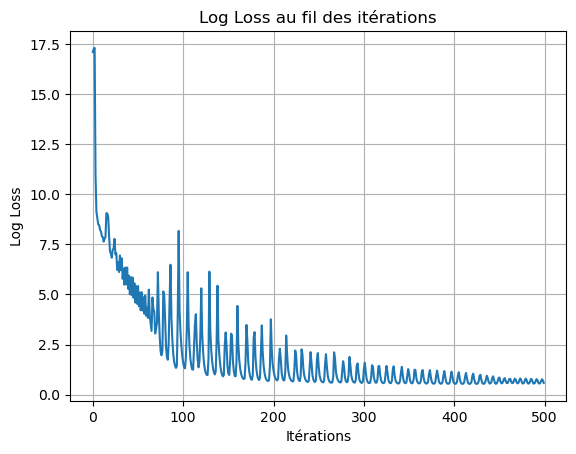

In [12]:
# Entraînement
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

params = deep_neural_network(X_train, y_train, hidden_layers=(256,128,64), n_iter=500, learning_rate=0.01)


In [13]:
# Prédiction et accuracy
y_pred_test = predict(X_test, params)
acc = accuracy(y_test, y_pred_test.astype(int))
print(f"Accuracy sur le jeu de test : {acc * 100:.2f}%")

Accuracy sur le jeu de test : 75.41%


In [14]:
import pickle

with open('params_model.pkl', 'wb') as f:
    pickle.dump(params, f)

normalization_stats = {'mu': mu, 'sigma': sigma}
with open('normalization_stats.pkl', 'wb') as f:
    pickle.dump(normalization_stats, f)



# Sauvegarde des infos catégories (pour ré-encoder dans Flask)
import pickle
with open('categories.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)
